In [1]:
import pandas as pd
import numpy as np
import shap

# Сбор датасета + создание производных фичей

## Сбор датасета

In [2]:
df = pd.read_pickle("../sybil_features_all_addresses.pickle")
df

,tx_count,active_days,lifetime_days,mean_tx_interval,median_tx_interval,std_tx_interval,max_tx_interval,fast_tx_ratio,short_interval_ratio,tx_per_day,...,peak_hour,peak_hour_ratio,hour_entropy,weekend_tx_ratio,unique_tx_types,tx_type_entropy,confirmations_mean,confirmations_std,low_conf_ratio,address
0,20,7,77.844190,3.539862e+05,2924.0,7.086010e+05,2544743.0,0.200000,0.250000,2.857143,...,4,0.350000,1.915765,0.050000,3,0.730588,1.501222e+08,6.539440e+07,0.250000,0xd6614286c4fdbdd4d39f153fc13b53368b3bd0b8
1,24,6,272.470127,1.023540e+06,170.0,4.696790e+06,22562155.0,0.291667,0.416667,4.000000,...,10,0.416667,1.517852,0.416667,3,1.063521,1.445570e+08,9.189451e+07,0.250000,0x01e1b85434391d6965de8b35acbb8884059afae7
2,145,44,478.125579,2.868753e+05,268.5,1.085975e+06,10794773.0,0.082759,0.172414,3.295455,...,18,0.186207,2.632444,0.558621,3,0.649059,1.738306e+08,7.258849e+07,0.248276,0xf0c58b786a35c767682c907a82ba5455490b3591
3,54,17,173.653148,2.830874e+05,28.0,1.052020e+06,6980659.0,0.370370,0.518519,3.176471,...,8,0.240741,2.271567,0.351852,3,0.979288,2.105488e+08,8.317516e+07,0.240741,0xed313446dbfbec87900fe0a7dfde688f744a3819
4,308,42,533.474502,1.501374e+05,47.0,6.986825e+05,7339859.0,0.275974,0.545455,7.333333,...,5,0.250000,2.317984,0.577922,3,0.909097,1.859688e+08,8.184623e+07,0.246753,0xdb686a9b77bc516a5fce6307a6ca58f6cbde1e3a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56891,596,73,267.778924,3.888420e+04,91.0,2.005161e+05,2985210.0,0.208054,0.439597,8.164384,...,19,0.184564,2.395846,0.337248,3,0.961837,1.434240e+08,6.525561e+07,0.250000,0xe0768e83840e09dc85c53833a9d3b4d16185fcfb
56892,108,26,377.828843,3.050880e+05,191.0,9.954825e+05,7303444.0,0.240741,0.425926,4.153846,...,12,0.351852,2.156182,0.157407,3,0.876516,1.849920e+08,6.498987e+07,0.250000,0xdb433bc5d23f2cdbdfcd96a0dcb73891b5f122d6
56893,240,56,810.174595,2.928832e+05,39.0,1.524632e+06,21399012.0,0.383333,0.533333,4.285714,...,7,0.150000,2.651510,0.345833,3,0.929510,2.031344e+08,8.090620e+07,0.250000,0x1d5e033ae2aa830bf7621c6349e0a00e3e071402
56894,434,67,148.937326,2.971867e+04,45.0,9.770210e+04,1107368.0,0.301843,0.534562,6.477612,...,8,0.135945,2.675979,0.278802,3,0.872723,1.224184e+08,3.990044e+07,0.251152,0xe98f0276a5f59c2b54886a17b0a2fac717915510


In [3]:
df_target = pd.read_pickle("../df_addresses.pickle").drop(
    columns=["index", "airdropped_tokens"]
)
df_target["sybil"] = (df_target["get_drop"] - 1).abs()
df_target = df_target.drop(columns="get_drop")
df_target

,user,sybil
0,0x934204e4617792b8ec2a34f0330a19ab3393041f,1
1,0xa99979dca47c7c41262936521d59d9a922f7a1d2,1
2,0x5fc7b11e3281b7404573465bc99d9aebc87ec59b,1
3,0x7c56d095261c0c9921adf95212f499018340bdde,0
4,0xa33f601b04ba846586266bfae01ae47d5362eff4,0
...,...,...
745228,0x5e73cf9cebd82d8c192f538f41186b55965e6fc6,0
745229,0x335b7c6633a29e43dbe2f7804803cc8243f2a830,0
745230,0xecebbda750e02674eab8929c69e9de5b30c4446f,0
745231,0x45d1d1124a10dafdf0fe6c6e12a1dea9c1c6db25,0


In [4]:
df = df.merge(df_target, left_on="address", right_on="user", how="inner").drop(
    columns=["user"]
)
df

,tx_count,active_days,lifetime_days,mean_tx_interval,median_tx_interval,std_tx_interval,max_tx_interval,fast_tx_ratio,short_interval_ratio,tx_per_day,...,peak_hour_ratio,hour_entropy,weekend_tx_ratio,unique_tx_types,tx_type_entropy,confirmations_mean,confirmations_std,low_conf_ratio,address,sybil
0,20,7,77.844190,3.539862e+05,2924.0,7.086010e+05,2544743.0,0.200000,0.250000,2.857143,...,0.350000,1.915765,0.050000,3,0.730588,1.501222e+08,6.539440e+07,0.250000,0xd6614286c4fdbdd4d39f153fc13b53368b3bd0b8,0
1,24,6,272.470127,1.023540e+06,170.0,4.696790e+06,22562155.0,0.291667,0.416667,4.000000,...,0.416667,1.517852,0.416667,3,1.063521,1.445570e+08,9.189451e+07,0.250000,0x01e1b85434391d6965de8b35acbb8884059afae7,0
2,145,44,478.125579,2.868753e+05,268.5,1.085975e+06,10794773.0,0.082759,0.172414,3.295455,...,0.186207,2.632444,0.558621,3,0.649059,1.738306e+08,7.258849e+07,0.248276,0xf0c58b786a35c767682c907a82ba5455490b3591,0
3,54,17,173.653148,2.830874e+05,28.0,1.052020e+06,6980659.0,0.370370,0.518519,3.176471,...,0.240741,2.271567,0.351852,3,0.979288,2.105488e+08,8.317516e+07,0.240741,0xed313446dbfbec87900fe0a7dfde688f744a3819,0
4,308,42,533.474502,1.501374e+05,47.0,6.986825e+05,7339859.0,0.275974,0.545455,7.333333,...,0.250000,2.317984,0.577922,3,0.909097,1.859688e+08,8.184623e+07,0.246753,0xdb686a9b77bc516a5fce6307a6ca58f6cbde1e3a,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56891,596,73,267.778924,3.888420e+04,91.0,2.005161e+05,2985210.0,0.208054,0.439597,8.164384,...,0.184564,2.395846,0.337248,3,0.961837,1.434240e+08,6.525561e+07,0.250000,0xe0768e83840e09dc85c53833a9d3b4d16185fcfb,0
56892,108,26,377.828843,3.050880e+05,191.0,9.954825e+05,7303444.0,0.240741,0.425926,4.153846,...,0.351852,2.156182,0.157407,3,0.876516,1.849920e+08,6.498987e+07,0.250000,0xdb433bc5d23f2cdbdfcd96a0dcb73891b5f122d6,0
56893,240,56,810.174595,2.928832e+05,39.0,1.524632e+06,21399012.0,0.383333,0.533333,4.285714,...,0.150000,2.651510,0.345833,3,0.929510,2.031344e+08,8.090620e+07,0.250000,0x1d5e033ae2aa830bf7621c6349e0a00e3e071402,0
56894,434,67,148.937326,2.971867e+04,45.0,9.770210e+04,1107368.0,0.301843,0.534562,6.477612,...,0.135945,2.675979,0.278802,3,0.872723,1.224184e+08,3.990044e+07,0.251152,0xe98f0276a5f59c2b54886a17b0a2fac717915510,0


## Feature engineering

In [5]:
# import random

# exclude_cols = ['address', 'sybil']

# # Столбцы, с которыми будем работать
# feature_cols = [col for col in df.columns if col not in exclude_cols]

# # Создаем копию датафрейма, чтобы добавлять новые признаки
# new_df = df.copy()

# # Перемножение всех возможных пар
# for col1 in feature_cols:
#     for col2 in feature_cols:
#         if random.uniform(0, 1) < 0.9:
#             continue
#         new_col_name = f'{col1}_mul_{col2}'
#         new_df[new_col_name] = new_df[col1] * new_df[col2]

# # Деление всех возможных пар
# for col1 in feature_cols:
#     for col2 in feature_cols:
#         if random.uniform(0, 1) < 0.9:
#             continue
#         new_col_name = f'{col1}_div_{col2}'
#         # Заменяем нули на 0.01 для делителя
#         divisor = new_df[col2].replace(0, 0.01)
#         new_df[new_col_name] = new_df[col1] / divisor


# df = new_df

In [6]:
np.random.seed(42)  # Чтобы результаты были воспроизводимыми
df["noise_feature"] = np.random.normal(loc=0, scale=1, size=len(df))

In [7]:
df

,tx_count,active_days,lifetime_days,mean_tx_interval,median_tx_interval,std_tx_interval,max_tx_interval,fast_tx_ratio,short_interval_ratio,tx_per_day,...,hour_entropy,weekend_tx_ratio,unique_tx_types,tx_type_entropy,confirmations_mean,confirmations_std,low_conf_ratio,address,sybil,noise_feature
0,20,7,77.844190,3.539862e+05,2924.0,7.086010e+05,2544743.0,0.200000,0.250000,2.857143,...,1.915765,0.050000,3,0.730588,1.501222e+08,6.539440e+07,0.250000,0xd6614286c4fdbdd4d39f153fc13b53368b3bd0b8,0,0.496714
1,24,6,272.470127,1.023540e+06,170.0,4.696790e+06,22562155.0,0.291667,0.416667,4.000000,...,1.517852,0.416667,3,1.063521,1.445570e+08,9.189451e+07,0.250000,0x01e1b85434391d6965de8b35acbb8884059afae7,0,-0.138264
2,145,44,478.125579,2.868753e+05,268.5,1.085975e+06,10794773.0,0.082759,0.172414,3.295455,...,2.632444,0.558621,3,0.649059,1.738306e+08,7.258849e+07,0.248276,0xf0c58b786a35c767682c907a82ba5455490b3591,0,0.647689
3,54,17,173.653148,2.830874e+05,28.0,1.052020e+06,6980659.0,0.370370,0.518519,3.176471,...,2.271567,0.351852,3,0.979288,2.105488e+08,8.317516e+07,0.240741,0xed313446dbfbec87900fe0a7dfde688f744a3819,0,1.523030
4,308,42,533.474502,1.501374e+05,47.0,6.986825e+05,7339859.0,0.275974,0.545455,7.333333,...,2.317984,0.577922,3,0.909097,1.859688e+08,8.184623e+07,0.246753,0xdb686a9b77bc516a5fce6307a6ca58f6cbde1e3a,1,-0.234153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56891,596,73,267.778924,3.888420e+04,91.0,2.005161e+05,2985210.0,0.208054,0.439597,8.164384,...,2.395846,0.337248,3,0.961837,1.434240e+08,6.525561e+07,0.250000,0xe0768e83840e09dc85c53833a9d3b4d16185fcfb,0,-2.206185
56892,108,26,377.828843,3.050880e+05,191.0,9.954825e+05,7303444.0,0.240741,0.425926,4.153846,...,2.156182,0.157407,3,0.876516,1.849920e+08,6.498987e+07,0.250000,0xdb433bc5d23f2cdbdfcd96a0dcb73891b5f122d6,0,0.680185
56893,240,56,810.174595,2.928832e+05,39.0,1.524632e+06,21399012.0,0.383333,0.533333,4.285714,...,2.651510,0.345833,3,0.929510,2.031344e+08,8.090620e+07,0.250000,0x1d5e033ae2aa830bf7621c6349e0a00e3e071402,0,0.695677
56894,434,67,148.937326,2.971867e+04,45.0,9.770210e+04,1107368.0,0.301843,0.534562,6.477612,...,2.675979,0.278802,3,0.872723,1.224184e+08,3.990044e+07,0.251152,0xe98f0276a5f59c2b54886a17b0a2fac717915510,0,-0.479493


# Учим черновую модель

In [8]:
from catboost import CatBoostClassifier, Pool, cv
import pandas as pd
import matplotlib.pyplot as plt

# 1. Загрузка данных
X = df.drop(["address", "sybil"], axis=1)
y = df["sybil"]
data_pool = Pool(X, y)

# 2. Параметры и кросс-валидация с сохранением моделей
params = {
    "loss_function": "Logloss",
    "use_best_model": True,
    "eval_metric": "AUC",
    "custom_metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "MCC"],
    "random_seed": 42,
    "depth": 8,  # 6 #7 #8
    "learning_rate": 0.02,  # 0.05
    "l2_leaf_reg": 5,
    "iterations": 2000,  # 1000
    "verbose": False,
}

cv_results = cv(
    params=params,
    pool=data_pool,
    plot=True,
    fold_count=3,
    stratified=True,
    shuffle=True,
    return_models=True,
    early_stopping_rounds=50,
    verbose=False,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.8917908096
bestIteration = 1999

Training on fold [1/3]

bestTest = 0.8926839222
bestIteration = 1999

Training on fold [2/3]

bestTest = 0.8912837754
bestIteration = 1999



In [20]:
np.mean(y)

np.float64(0.20120922384701911)

In [9]:
selected_features = []
for model in cv_results[1]:
    feature_importances = model.get_feature_importance(prettified=True)
    feature_importances.columns = ["feature", "importance"]

    # Ищем importance у 'noise_feature'
    noise_importance = feature_importances[
        feature_importances["feature"] == "noise_feature"
    ]["importance"].values[0]

    # Оставляем только те фичи, у которых важность больше, чем у noise_feature
    selected_features += [
        list(
            feature_importances[feature_importances["importance"] > noise_importance][
                "feature"
            ]
        )
    ]

intersection = set(selected_features[0])
for lst in selected_features[1:]:
    intersection &= set(lst)

print(len(intersection))
intersection

52


{'active_days',
 'below_q1_ratio',
 'confirmations_mean',
 'confirmations_std',
 'contract_call_ratio',
 'distinct_contract_ratio',
 'duplicate_tx_ratio',
 'fast_tx_ratio',
 'gas_used_ratio_mean',
 'hour_entropy',
 'incoming_value_eth',
 'lifetime_days',
 'max_nonce_gap',
 'max_tx_interval',
 'max_value_eth',
 'mean_block_gap',
 'mean_gas_bid_ratio',
 'mean_gas_eth',
 'mean_gas_price',
 'mean_nonce_gap',
 'mean_tx_interval',
 'mean_value_eth',
 'median_tx_interval',
 'median_value_eth',
 'most_common_value',
 'most_common_value_freq',
 'most_common_value_ratio',
 'net_value_eth',
 'out_in_ratio',
 'outgoing_value_eth',
 'peak_hour',
 'peak_hour_ratio',
 'receiver_per_tx',
 'short_interval_ratio',
 'std_block_gap',
 'std_gas_eth',
 'std_gas_price',
 'std_tx_interval',
 'std_value_eth',
 'token_tx_ratio',
 'total_gas_eth',
 'total_value_eth',
 'tx_per_day',
 'tx_type_entropy',
 'unique_methodIds',
 'unique_methods',
 'unique_receivers',
 'unique_senders',
 'value_entropy',
 'value_gini',

In [21]:
list(intersection)

['unique_methods',
 'confirmations_mean',
 'std_gas_eth',
 'peak_hour',
 'hour_entropy',
 'out_in_ratio',
 'max_tx_interval',
 'tx_type_entropy',
 'mean_gas_bid_ratio',
 'std_value_eth',
 'below_q1_ratio',
 'fast_tx_ratio',
 'mean_block_gap',
 'median_value_eth',
 'weekend_tx_ratio',
 'lifetime_days',
 'total_value_eth',
 'incoming_value_eth',
 'token_tx_ratio',
 'mean_tx_interval',
 'std_gas_price',
 'outgoing_value_eth',
 'active_days',
 'mean_value_eth',
 'tx_per_day',
 'max_value_eth',
 'unique_senders',
 'contract_call_ratio',
 'mean_nonce_gap',
 'most_common_value_freq',
 'duplicate_tx_ratio',
 'zero_value_tx_ratio',
 'confirmations_std',
 'short_interval_ratio',
 'most_common_value_ratio',
 'distinct_contract_ratio',
 'unique_receivers',
 'total_gas_eth',
 'most_common_value',
 'std_block_gap',
 'unique_methodIds',
 'net_value_eth',
 'mean_gas_eth',
 'mean_gas_price',
 'gas_used_ratio_mean',
 'max_nonce_gap',
 'value_gini',
 'std_tx_interval',
 'value_entropy',
 'median_tx_inter

# Учим нечерновую модель

In [11]:
from catboost import Pool, cv
import pandas as pd

# 1. Загрузка данных
X = df.drop(["address", "sybil"], axis=1)[list(intersection)]
y = df["sybil"]
data_pool = Pool(X, y)

# 2. Параметры и кросс-валидация с сохранением моделей
params = {
    "loss_function": "Logloss",
    "use_best_model": True,
    "eval_metric": "AUC",
    "custom_metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "MCC"],
    "random_seed": 42,
    "depth": 8,  # 6 #7 #8
    "learning_rate": 0.01,  # 0.05
    "l2_leaf_reg": 3,
    "iterations": 6000,  # 1000
    "verbose": False,
}

cv_results = cv(
    params=params,
    pool=data_pool,
    plot=True,
    fold_count=5,
    stratified=True,
    shuffle=True,
    return_models=True,
    early_stopping_rounds=50,
    verbose=False,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9118140286
bestIteration = 5993

Training on fold [1/5]

bestTest = 0.9007249917
bestIteration = 5998

Training on fold [2/5]

bestTest = 0.9072999986
bestIteration = 5999

Training on fold [3/5]

bestTest = 0.9115910278
bestIteration = 5998

Training on fold [4/5]

bestTest = 0.9033440054
bestIteration = 5999



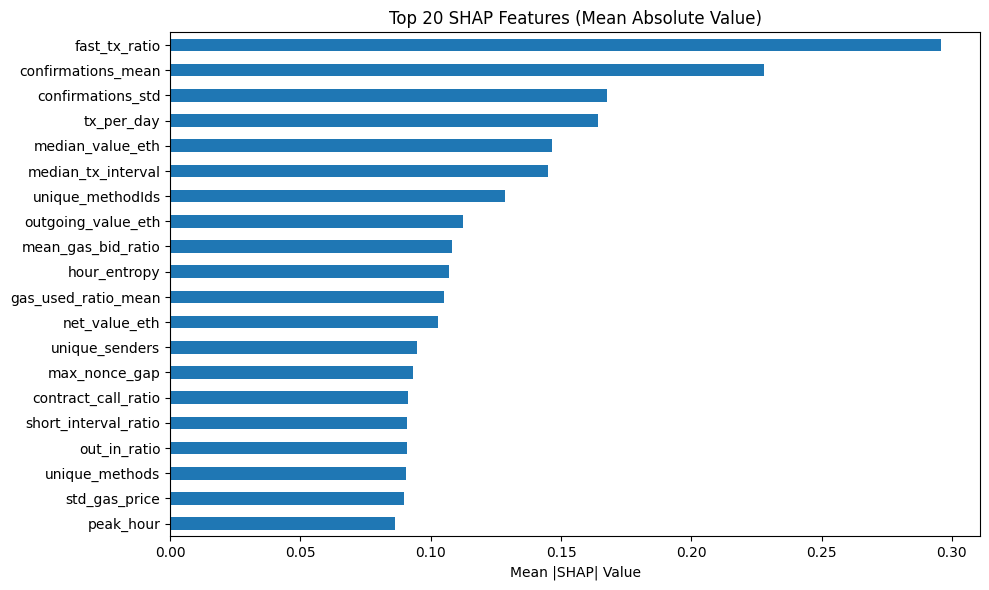

SHAP summary plot for first fold model:


/tmp/ipykernel_5314/191569067.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, max_display=20)


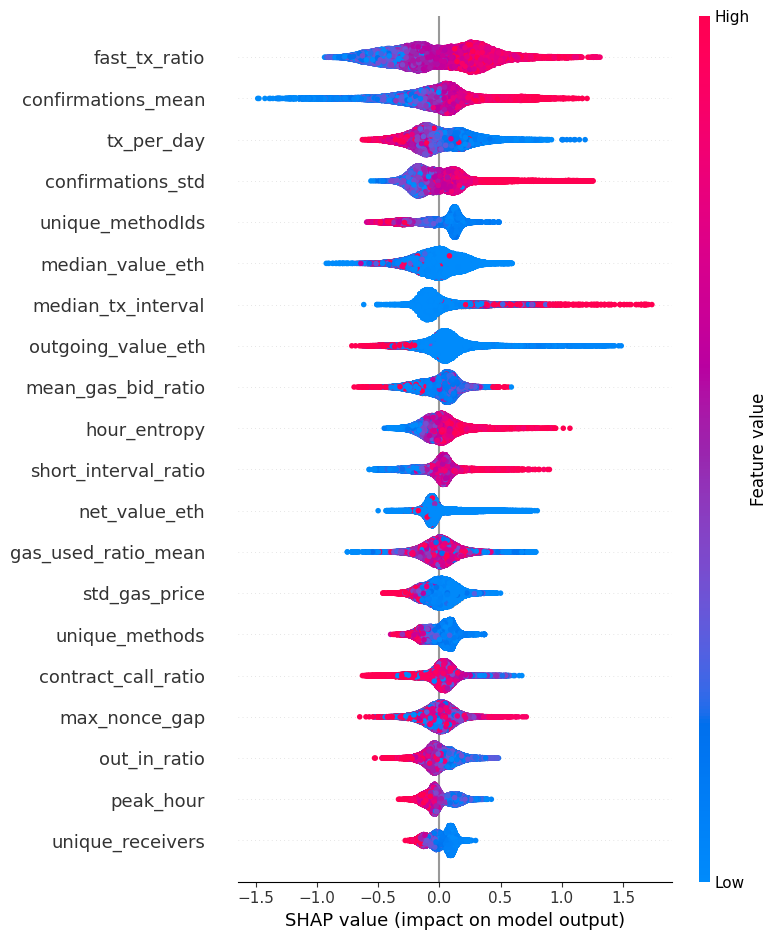

In [ ]:
models = cv_results[1]

# 3. Вычисление SHAP значений и агрегация
shap_values_all = []
for model in models:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_values_all.append(np.abs(shap_values))  # абсолютные значения SHAP

# 4. Среднее значение SHAP по фолдам
shap_values_mean = np.mean(shap_values_all, axis=0)  # по фолдам
shap_df = pd.DataFrame(shap_values_mean, columns=X.columns)
shap_importance = shap_df.mean().sort_values(ascending=False)

# 5. Визуализация: Bar-график важности признаков
top_n = 20
plt.figure(figsize=(10, 6))
shap_importance.head(top_n).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} SHAP Features (Mean Absolute Value)")
plt.xlabel("Mean |SHAP| Value")
plt.tight_layout()
plt.show()

# 6. (Опционально) SHAP summary plot на одной модели (например, 1-й фолд)
print("SHAP summary plot for first fold model:")
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=20)

Bar plot saved to shap_importance.png


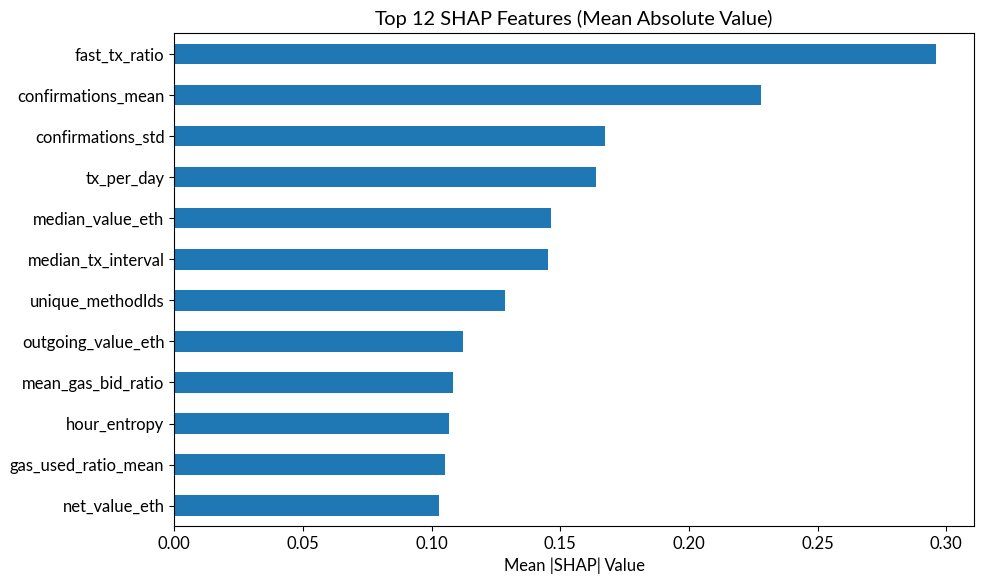

/tmp/ipykernel_5314/3022863436.py:62: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, max_display=12, show=False)


Summary plot saved to shap_summary.png


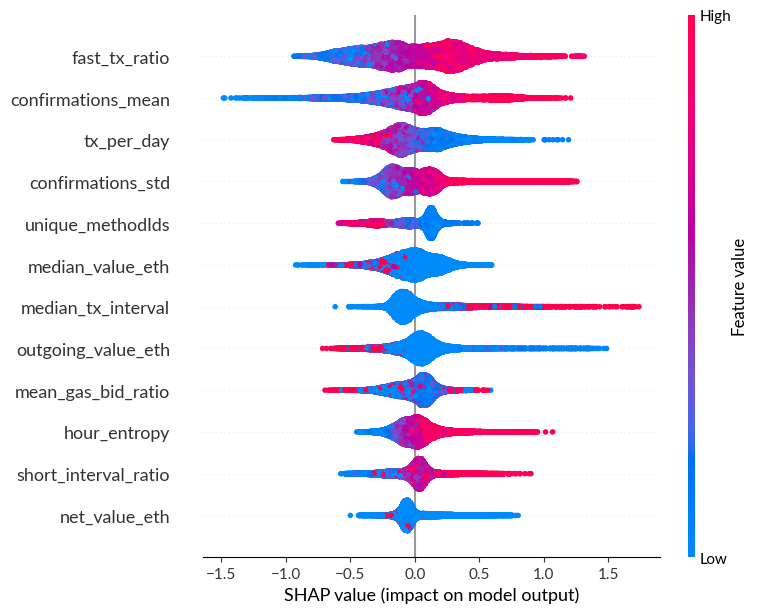

In [41]:
import os

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1. Указываем директорию с Lato (где у вас лежат .ttf)
lato_dir = "/usr/share/fonts/truetype/lato"

# 2. Регистрируем все .ttf из этой папки в текущей сессии Matplotlib
for fname in os.listdir(lato_dir):
    if fname.lower().endswith(".ttf"):
        fm.fontManager.addfont(os.path.join(lato_dir, fname))

# 3. (Опционально) Если вы хотите полностью пересоздать список шрифтов:
#    более «грубый» способ — собрать список заново только из вашей папки Lato,
#    но это заменит весь список шрифтов:
# all_fonts = fm.findSystemFonts(fontpaths=[lato_dir], fontext='ttf')
# fm.fontManager.ttflist = fm.createFontList(all_fonts)

# 4. Теперь можно смело указывать Lato в rcParams
plt.rcParams["font.family"] = "Lato"
plt.rcParams["font.sans-serif"] = ["Lato"]
plt.rcParams["font.size"] = 12
# 1. Допустим, у вас уже есть models = cv_results[1] и матрица X

# # 2. Расчёт SHAP и агрегация по фолдам
# shap_values_all = []
# for model in models:
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X)
#     shap_values_all.append(np.abs(shap_values))

# shap_values_mean = np.mean(shap_values_all, axis=0)
# shap_df = pd.DataFrame(shap_values_mean, columns=X.columns)
# shap_importance = shap_df.mean().sort_values(ascending=False)

# 3. Визуализация: Bar-график важности признаков
top_n = 12
fig, ax = plt.subplots(figsize=(10, 6))
shap_importance.head(top_n).plot(kind="barh", ax=ax)
ax.invert_yaxis()
ax.set_title(f"Top {top_n} SHAP Features (Mean Absolute Value)", fontfamily="Lato")
ax.set_xlabel("Mean |SHAP| Value", fontfamily="Lato")
plt.tight_layout()

# 4. Сохранение с прозрачным фоном
output_path = "shap_importance.png"
fig.savefig(output_path, dpi=300, transparent=True)
print(f"Bar plot saved to {output_path}")

# 5. Отобразить на экране (опционально)
plt.show()

# 6. SHAP summary plot для первой модели
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(X)

# Можно также задать больший размер фигуры и шрифт через rcParams
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, max_display=12, show=False)
plt.tight_layout()

# Сохранение summary-plot
summary_path = "shap_summary.png"
plt.savefig(summary_path, dpi=300, transparent=True)
print(f"Summary plot saved to {summary_path}")

# И, при желании, отобразить
plt.show()

# Инференс и попытка привести к реальной вероятности

In [63]:
model = CatBoostClassifier()
model.load_model("catboost_info/fold-0/model")

preds = model.predict(Pool(data=X), prediction_type="Probability")[:, 1]


for i in range(1, 5):
    model = CatBoostClassifier()
    model.load_model(f"catboost_info/fold-{i}/model")

    preds += model.predict(Pool(data=X), prediction_type="Probability")[:, 1]
    preds

preds = preds / 5

   threshold  precision  recall
0   0.000053   0.201209     1.0
1   0.000068   0.201213     1.0
2   0.000082   0.201216     1.0
3   0.000083   0.201220     1.0
4   0.000085   0.201223     1.0
5   0.000085   0.201227     1.0
6   0.000086   0.201230     1.0
7   0.000092   0.201234     1.0
8   0.000093   0.201238     1.0
9   0.000095   0.201241     1.0


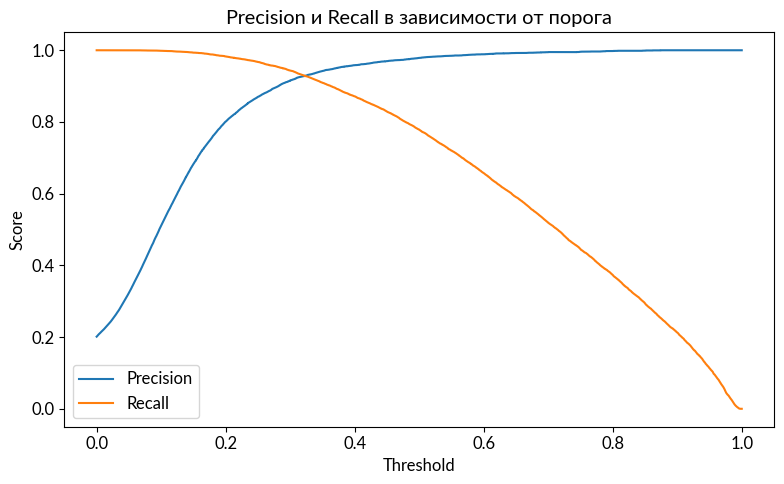

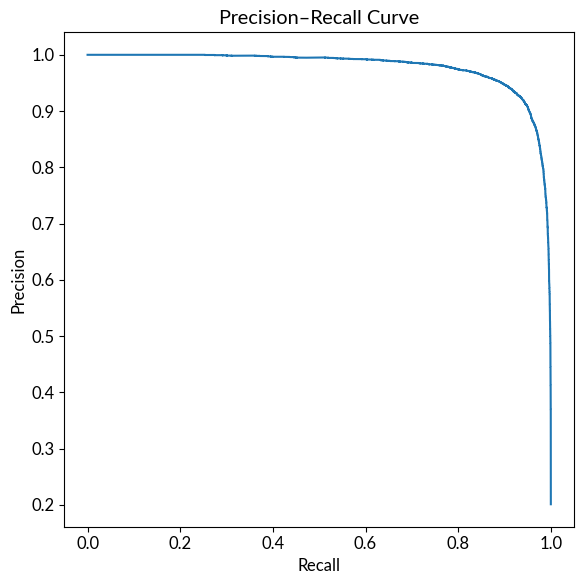

In [65]:
from sklearn.metrics import precision_recall_curve

y_scores = preds  # вероятность класса «1»

# 2. Вычисляем Precision, Recall и соответствующие thresholds
precision, recall, thresholds = precision_recall_curve(y, y_scores)

# note: thresholds.shape = (len(precision)-1,)
# чтобы выровнять длины, обычно добавляют фиктивный порог 1.0 в конец:
thresholds_full = np.append(thresholds, 1.0)

# 3. Смотрим данные в табличке
pr_df = pd.DataFrame(
    {"threshold": thresholds_full, "precision": precision, "recall": recall}
)
print(pr_df.head(10))

# 4. Строим график Precision и Recall vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds_full, precision, label="Precision")
plt.plot(thresholds_full, recall, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision и Recall в зависимости от порога")
plt.legend()
plt.tight_layout()
plt.show()

# 5. (Опционально) Классический Precision–Recall curve
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.show()

In [66]:
pr_df

,threshold,precision,recall
0,0.000053,0.201209,1.000000
1,0.000068,0.201213,1.000000
2,0.000082,0.201216,1.000000
3,0.000083,0.201220,1.000000
4,0.000085,0.201223,1.000000
...,...,...,...
56842,0.996615,1.000000,0.000349
56843,0.996915,1.000000,0.000262
56844,0.997332,1.000000,0.000175
56845,0.997513,1.000000,0.000087


In [67]:
for i in range(20):
    print(pr_df[pr_df["precision"] >= 0.05 * i].head(1))

   threshold  precision  recall
0   0.000053   0.201209     1.0
   threshold  precision  recall
0   0.000053   0.201209     1.0
   threshold  precision  recall
0   0.000053   0.201209     1.0
   threshold  precision  recall
0   0.000053   0.201209     1.0
   threshold  precision  recall
0   0.000053   0.201209     1.0
       threshold  precision  recall
11103   0.024642       0.25     1.0
       threshold  precision    recall
18727   0.042762   0.300005  0.999913
       threshold  precision    recall
24179   0.057645   0.350009  0.999825
       threshold  precision    recall
28274   0.071435   0.400007  0.999563
       threshold  precision    recall
31460   0.084247       0.45  0.999214
       threshold  precision    recall
34011   0.097071        0.5  0.998777
       threshold  precision    recall
36110   0.110619   0.550002  0.997816
       threshold  precision    recall
37847   0.125029   0.600011  0.996244
       threshold  precision    recall
39325   0.139618   0.650006  0.995108
